# ***OCON Model Analysis***
*(12-features Complete Dataset)*

**Author:** S. Giacomelli

**Year:** 2023

**Affiliation:** A.Casella Conservatory (student)

**Master Degree Thesis**: "*Vowel phonemes Analysis & Classification by means of OCON rectifiers Deep Learning Architectures*"

**Description:** Python scripts for One-Class-One-Network (OCON) Model analysis and optimization

In [ ]:
# Numerical computations packages/modules
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dataset processing modules
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Graphic visualization modules
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Common Seed initialization
SEED = 42  # ... the answer to the ultimate question of Life, the Universe, and Everything... (cit.)

# PyTorch Processing Units evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'AVILABLE Processing Unit: {device.upper()}')
!nvidia-smi

AVILABLE Processing Unit: CPU
/bin/bash: nvidia-smi: command not found


## **HGCW Dataset**

- *Dataset_utils.npz* file read
- *One-Hot encoding* definition
- *Train/Dev/Test split* definition

In [ ]:
# Load HGCW 12_features_all Dataset
HGCW_dataset_utils = np.load(file='./HGCW_dataset_utils.npz')
print('Raw features                    Data shape:', HGCW_dataset_utils['HGCW_raw'].shape)
print('Fundamental Normalized features Data shape:', HGCW_dataset_utils['HGCW_fund_norm'].shape)
print('MinMax features                 Data shape:', HGCW_dataset_utils['HGCW_minmax'].shape)
print('Labels                          Data shape:', HGCW_dataset_utils['HGCW_labels'].shape)
print('Classes size                    Data shape:', HGCW_dataset_utils['classes_size'].shape)
print('Classes indices                 Data shape:', HGCW_dataset_utils['classes_idx'].shape)

x_data_raw_np = HGCW_dataset_utils['HGCW_raw']
x_data_fund_norm = HGCW_dataset_utils['HGCW_fund_norm']
x_data_minmax = HGCW_dataset_utils['HGCW_minmax']
y_labels_raw_np = HGCW_dataset_utils['HGCW_labels']
vow_size = HGCW_dataset_utils['classes_size']
end_idx = HGCW_dataset_utils['classes_idx']

# Auxiliary lists
vowels = ['ae', 'ah', 'aw', 'eh', 'er', 'ei', 'ih', 'iy', 'oa', 'oo', 'uh', 'uw']  # Vowels list
colors = ['red', 'saddlebrown', 'darkorange', 'darkgoldenrod', 'gold', 'darkkhaki', 'olive', 'darkgreen', 'steelblue', 'fuchsia', 'indigo', 'black']

Raw features                    Data shape: (1597, 13)
Fundamental Normalized features Data shape: (1597, 13)
MinMax features                 Data shape: (1597, 13)
Labels                          Data shape: (1597, 1)
Classes size                    Data shape: (12,)
Classes indices                 Data shape: (13,)


In [ ]:
# Class-specific One-hot encoding (Binarization)
def one_hot_encoder(sel_class_number: int = 3, dataset: np.ndarray = x_data_minmax, orig_labels: int = len(vowels), classes_size: list = vow_size, classes_idx: list = end_idx, debug=False):

    classes = [n for n in range(orig_labels)]  # Class Labels list initialization

    # Auxiliary Parameters Initialization
    if sel_class_number < len(classes):
        classes.remove(sel_class_number)  # REST Classes list
        if debug is True:
            print(f'Selected Class "{vowels[sel_class_number]}" : {classes_size[sel_class_number]} samples')
        sub_classes_size = classes_size[sel_class_number] // len(classes)
        if debug is True:
            print(f'Rest Classes size (...each): {sub_classes_size} samples')

        # 1-Subset processing
        sub_data = dataset[classes_idx[sel_class_number]: classes_idx[sel_class_number + 1], :]  # Selected Class feature slicing
        sub_data_labels_bin = np.ones((classes_size[sel_class_number], 1), dtype='int')  # Selected Class labels (1) creation
        sub_data_labels = np.ones((classes_size[sel_class_number], 1), dtype='int') * sel_class_number

        # 0-Subset processing
        for i in classes:
            class_i_indices = np.random.choice(np.arange(classes_idx[i], classes_idx[i + 1], 1), size=sub_classes_size, replace=False)
            sub_class_i_array = dataset[class_i_indices, :]
            sub_class_labels_bin_array = np.zeros((sub_class_i_array.shape[0], 1), dtype='int')  # Rest I-esimal Class labels (0) creation
            sub_class_labels_array = np.ones((sub_class_i_array.shape[0], 1), dtype='int') * i

            # Outputs append
            sub_data = np.vstack((sub_data, sub_class_i_array))
            sub_data_labels_bin = np.vstack((sub_data_labels_bin, sub_class_labels_bin_array))
            sub_data_labels = np.vstack((sub_data_labels, sub_class_labels_array))
    else:
        raise ValueError(f'Invalid Class ID: "{sel_class_number}" --> It must be less than {len(classes)}!')

    return sub_data, sub_data_labels_bin, sub_data_labels

In [ ]:
# Train/Test split (auxiliary function)
def train_test_split_aux(features_dataset, labels_dataset, test_perc, tolerance):
    """
    An auxiliary Train_Test_split function (based on Scikit Learn implementation) w. balance tolerance specification
    """
    test_size = int(test_perc / 100 * len(features_dataset))
    train_balance = 0  # Output Training set balance value initialization
    test_balance = 0  # Output Testing set balance value initialization

    min_tol = np.mean(labels_dataset) - tolerance
    max_tol = np.mean(labels_dataset) + tolerance
    print(f'Data Balancing  (TARGET = {np.mean(labels_dataset)} +- {tolerance}): ', end='')

    while (min_tol >= train_balance or train_balance >= max_tol) or (min_tol >= test_balance or test_balance >= max_tol):
        train_data, test_data, train_labels, test_labels = train_test_split(features_dataset, labels_dataset, test_size=test_size, shuffle=True)
        train_balance = np.mean(train_labels)
        test_balance = np.mean(test_labels)
        print('.', end='')
    else:
        print('OK')

    return train_data, test_data, train_labels, test_labels, train_balance, test_balance

# Train-Dev-Test split function
def train_dev_test_split(x_data, y_labels, split_list, tolerance=0.1, output='Loaders', debug=False):
    """
    Compute a Train, Development (Hold-Out) and a Test set split w. PyTorch Dataset conversion (and eventual Loaders initialization)
    """
    if len(split_list) == 3:
        # Train - Dev+Test separation
        print('Training --- Devel/Test SPLIT')
        train_data, testTMP_data, train_labels, testTMP_labels, _, _ = train_test_split_aux(x_data, y_labels, (split_list[1] * 100) + (split_list[2] * 100), tolerance)
        print('----------------------------------')

        # Dev - Test separation
        print('Devel    ---     Test SPLIT')

        split = ((split_list[1] * 100) / np.sum(split_list[1:] * 100)) * 100  # Split in %
        dev_data, test_data, dev_labels, test_labels, _, _ = train_test_split_aux(testTMP_data, testTMP_labels, split, tolerance)
        print('----------------------------------')

        # Tensor Conversion
        train_data_tensor = torch.tensor(train_data).float()
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64).squeeze()
        dev_data_tensor = torch.tensor(dev_data).float()
        dev_labels_tensor = torch.tensor(dev_labels, dtype=torch.int64).squeeze()
        test_data_tensor = torch.tensor(test_data).float()
        test_labels_tensor = torch.tensor(test_labels, dtype=torch.int64).squeeze()
        if debug is True:
            print(f'Training Data        Shape: {train_data.shape}')
            print(f'Development Data     Shape: {dev_data.shape}')
            print(f'Testing Data         Shape: {test_data.shape}')

            # Balance Evaluation
            print(f'Training Set       Balance: {np.mean(train_labels)}')
            print(f'Development Set    Balance: {np.mean(dev_labels)}')
            print(f'Testing Set        Balance: {np.mean(test_labels)}')

        if output != 'Loaders':
            return train_data_tensor, train_labels_tensor, dev_data_tensor, dev_labels_tensor, test_data_tensor, test_labels_tensor
        else:
            # PyTorch Dataset Conversion
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels, dtype=torch.int64).squeeze())
            dev_dataset = torch.utils.data.TensorDataset(torch.tensor(dev_data).float(), torch.tensor(dev_labels, dtype=torch.int64).squeeze())
            test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels, dtype=torch.int64).squeeze())

            # DataLoader (Batches) --> Drop-Last control to optimize training
            trainLoader = DataLoader(train_dataset, shuffle=False, batch_size = 32, drop_last=True)
            devLoader = DataLoader(dev_dataset, shuffle=False, batch_size = dev_dataset.tensors[0].shape[0])
            testLoader = DataLoader(test_dataset, shuffle=False, batch_size = test_dataset.tensors[0].shape[0])
            if debug is True:
                print(f'Training Set    Batch Size: {trainLoader.batch_size}')
                print(f'Development Set Batch Size: {devLoader.batch_size}')
                print(f'Testing Set     Batch Size: {testLoader.batch_size}')

            return trainLoader, devLoader, testLoader
    else:
        # Train - Test separation
        print('Training --- Test    SPLIT')
        train_data, test_data, train_labels, test_labels, _, _ = train_test_split_aux(x_data, y_labels, split_list[1] * 100, tolerance, debug=debug)
        print('--------------------------')

        # Tensor Conversion
        train_data_tensor = torch.tensor(train_data).float()
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64).squeeze()
        test_data_tensor = torch.tensor(test_data).float()
        test_labels_tensor = torch.tensor(test_labels, dtype=torch.int64).squeeze()
        if debug is True:
            print(f'Training Data        Shape: {train_data.shape}')
            print(f'Testing Data         Shape: {test_data.shape}')

            # Balance Evaluation
            print(f'Training Set    Balance: {np.mean(train_labels)}')
            print(f'Testing Set     Balance: {np.mean(test_labels)}')

        if output != 'Loaders':
            return train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor
        else:
            # PyTorch Dataset Conversion
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels, dtype=torch.int64).squeeze())
            test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels, dtype=torch.int64).squeeze())

            # DataLoader (Batches) --> Drop-Last control to optimize training
            trainLoader = DataLoader(train_dataset, shuffle=False, batch_size = 32, drop_last=True)
            testLoader = DataLoader(test_dataset, shuffle=False, batch_size = test_dataset.tensors[0].shape[0])
            if debug is True:
                print(f'Training Set    Batch Size: {trainLoader.batch_size}')
                print(f'Testing Set     Batch Size: {testLoader.batch_size}')

            return trainLoader, testLoader

## **One-Class Architecture** (Binary Classifier)
(see "*One-Class_Sub-Network_Analysis.ipynb*")

```
Multi-Layer Perceptron
- Input Layer: 3 features [formant ratios, min-max normalized]
- Hidden Layer: 100 units
- Output Layer: 1 normalized probability
- Learning Rate: 0.0001 (10^-4)
- Optimizer: Adam (Adaptive Momentum)

- Mini-Batch Training:
    . Re-iterated Sub-Dataset Shuffling
    . Early Stopping (Test Accuracy driven)
    . Batch size = 32

- Regularization:
    . Weight Decay (L2 Penalty): 0.0001 (10^-4)
    . DropOut:
        * Input Layer Drop Rate: 0.8
        * Hidden Layer Drop Rate: 0.5.
    . Batch Normalization
```

- *MLP Classifier Architecture* class definition
- *Mini-Batch Training* function definition

In [ ]:
# Dynamic Multi-Layer Architecture Class (w. units, activation function, batch normalization and dropOut rate specification)
class binaryClassifier(nn.Module):                                                # nn.Module: base class to inherit from
    def __init__(self, n_units, act_fun, rate_in, rate_hidden, model_name):                   # self + attributes (architecture hyper-parameters)
        super().__init__()

        self.layers = nn.ModuleDict()                                             # Dictionary to store Model layers
        self.name = model_name

        # Input Layer
        self.layers['input'] = nn.Linear(12, n_units)                              # Key 'input' layer specification

        # Hidden Layer
        self.layers[f'hidden'] = nn.Linear(n_units, n_units)
        self.layers[f'batch_norm'] = nn.BatchNorm1d(n_units)

        # Output Layer
        self.layers['output'] = nn.Linear(n_units, 1)                             # Key 'output' layer specification

        # Activation Function
        self.actfun = act_fun                                                     # Function string-name attribute association

        # Dropout Parameter
        self.dr_in = rate_in
        self.dr_hidden = rate_hidden

        # Weights & Bias initialization
        for layer in self.layers.keys():
            try:
                nn.init.kaiming_normal_(self.layers[layer].weight, mode='fan_in') # Kaiming He - Normal Distributed (ReLU specific)
            except:
                pass                                                              # Batch_norm Layer can't be initialized
            self.layers[layer].bias.data.fill_(0.)                                # Bias initialization (0.)

    # Forward Pass Method
    def forward(self, x):

        # Activation function object computation
        actfun = getattr(torch.nn, self.actfun)

        # Input Layer pass                                                        --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = actfun()(self.layers['input'](x))
        x = F.dropout(x, p=self.dr_in, training=self.training)                    # Activate DropOut only when Model Training == True

        # Single Hidden Layer pass                                                --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = self.layers[f'batch_norm'](x)                                         # Apply batch normalization before hidden layer
        x = actfun()(self.layers[f'hidden'](x))
        x = F.dropout(x, p=self.dr_hidden, training=self.training)                # Same as "Input pass"

        # Output Layer pass                                                       --> Output Weightening (Dot Product) "Linear transform" (Optimizer implement an Output Sigmoid sctivation)
        x = self.layers['output'](x)
        x = nn.Sigmoid()(x)

        return x

In [ ]:
# Batch Training function (w. Adam Optimizer & L2 penalty term) Re-Definition
def mini_batch_train_test(model, weight_decay, epochs: int, learning_rate, train_loader, dev_loader, test_loader, debug=False):
    """
    Train & Test an ANN Architecture via Mini-Batch Training (w. Train/Dev/Test PyTorch Loaders) and Adam Backpropagation Optimizer
    """
    # Loss Function initialization
    loss_function = nn.BCELoss()

    # Optimizer Algorithm initialization
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Output list initialization
    train_accuracies = []
    train_losses = []
    dev_accuracies = []

    # TRAINING Phase
    for epoch in range(epochs):
        model.train()  # TRAINING Switch ON

        batch_accuracies = []
        batch_losses = []

        # Training BATCHES Loop
        for data_batch, labels_batch in train_loader:
            train_predictions = model(data_batch)
            train_loss = loss_function(train_predictions.squeeze(), labels_batch.type(torch.int64).float())
            batch_losses.append(train_loss.detach())

            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Accuracy
            train_accuracy = 100 * torch.mean(((train_predictions.squeeze() > 0.5) == labels_batch.type(torch.int64).squeeze()).float())

            # Batch Stats appending
            batch_accuracies.append(train_accuracy.detach())
            batch_losses.append(train_loss.detach())

        # Training Stats appending
        train_accuracies.append(np.mean(batch_accuracies))  # Average of Batch Accuracies = Training step accuracy
        train_losses.append(np.mean(batch_losses))  # Average of Batch Losses = Training step Losses

        # EVALUATION (Dev) Phase
        model.eval()
        with torch.no_grad():
            dev_data_batch, dev_labels_batch = next(iter(dev_loader))
            dev_predictions = model(dev_data_batch)

            dev_accuracy = 100 * torch.mean(((dev_predictions.squeeze() > 0.5) == dev_labels_batch.type(torch.int64).squeeze()).float())

            if debug is True:
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} --> DEV ACCURACY: {dev_accuracy.detach():.3f} %')
                    print('--------------------------------')

            # Evaluation accuracy appending
            dev_accuracies.append(dev_accuracy.detach())

    # TEST Phase
    model.eval()
    with torch.no_grad():
        test_data_batch, test_labels_batch = next(iter(test_loader))
        test_predictions = model(test_data_batch)
        test_accuracy = 100 * torch.mean(((test_predictions.squeeze() > 0.5) == test_labels_batch.type(torch.int64).squeeze()).float())

        if debug is True:
            print(f'TEST ACCURACY: {test_accuracy.detach():.2f} %')
            print('--------------------------------------------------------------------')

    return train_accuracies, train_losses, dev_accuracies, test_accuracy.detach()

## **OCON (One-Class-One-Net)** Model

Binary classifiers **Parallelization**
-  *Classifiers-Bank* function definition
    - *Models Parameters* inspection
- Classifiers **Sequential** Training & Evaluation
- *Models Parameters State Save/Load* function definition

---

- MaxNet output algorithm
- Argmax output algorithm

In [ ]:
def OCON_bank(one_class_function, hidden_units, act_fun, dr_in, dr_hidden, classes_list):
    """
    Create a One-Class-One-Network parallelization bank of an input Sub-Network definition
    """
    # Sub-Net names creation
    models_name_list = []
    for i in range(len(classes_list)):
        models_name_list.append("{}_{}".format(classes_list[i], "subnet"))  # Class name + _subnet

    # Sub-Networks instances creation
    sub_nets = []  # Sub Network list initialization

    for i in range(len(models_name_list)):

        torch.manual_seed(SEED)  # Seed re-initialization

        # Sub-Net instance creation
        locals()[models_name_list[i]] = one_class_function(hidden_units, act_fun, dr_in, dr_hidden, models_name_list[i])
        sub_nets.append(locals()[models_name_list[i]])

    return sub_nets

In [ ]:
# Load Architecture Parameters State function
def load_model_state(model, state_dict_path):
    """
    Load an existent State Dictionary in a defined model
    """

    model.load_state_dict(torch.load(state_dict_path))
    print(f'Loaded Parameters (from "{state_dict_path}") into: {model.name}')

    return model

In [ ]:
# Build The OCON Model
ocon_vowels = OCON_bank(binaryClassifier, 100, 'ReLU', 0.8, 0.5, vowels)  # Best MLP (see "One-Class_Binary_Classifier_Analysis.ipynb")

# Load Pre-Trained Architectures in a fresh Model instance:
#ocon_vowels = OCON_bank(binaryClassifier, 100, 'ReLU', 0.8, 0.5, vowels)  # Best MLP (see "One-Class_Binary_Classifier_Analysis.ipynb")
#states_path = ["Trained_models_state/ae_subnet_Params.pth",
#               "Trained_models_state/ah_subnet_Params.pth",
#               "Trained_models_state/aw_subnet_Params.pth",
#               "Trained_models_state/eh_subnet_Params.pth",
#               "Trained_models_state/er_subnet_Params.pth",
#               "Trained_models_state/ei_subnet_Params.pth",
#               "Trained_models_state/ih_subnet_Params.pth",
#               "Trained_models_state/iy_subnet_Params.pth",
#               "Trained_models_state/oa_subnet_Params.pth",
#               "Trained_models_state/oo_subnet_Params.pth",
#               "Trained_models_state/uh_subnet_Params.pth",
#               "Trained_models_state/uw_subnet_Params.pth"]
#
#for i in range(len(ocon_vowels)):
#    load_model_state(ocon_vowels[i], states_path[i])

In [ ]:
# OCON Evaluation function
def OCON_eval(ocon_models_bank, features_dataset: np.ndarray = x_data_minmax[:, 1:], labels: np.ndarray = y_labels_raw_np):
    """
    Evaluate OCON models-bank over an entire dataset
    """
    # Output lists initialization
    predictions = []
    dist_errors = []
    eval_accuracies = []
    g_truths = []  # For plotting purpouses

    # Evaluate each Sub-Network...
    for i in range(len(ocon_models_bank)):
        ocon_models_bank[i].eval()  # Put j-esimal Sub-Network in Evaluation Mode
        print(f'{ocon_models_bank[i].name.upper()} Evaluation -', end=' ')

        with torch.no_grad():

            # Make predictions
            features_data_tensor = torch.tensor(features_dataset).float()
            raw_eval_predictions = ocon_models_bank[i](features_data_tensor)

            # Create Ground Truths
            ground_truth = np.where(labels == i, 1, 0)
            ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.int64).squeeze()

            # Compute Errors
            dist_error = ground_truth_tensor - raw_eval_predictions.detach().squeeze()  # Distances
            eval_accuracy = 100 * torch.mean(((raw_eval_predictions.detach().squeeze() > 0.5) == ground_truth_tensor).float())
            print(f'Accuracy: {eval_accuracy:.2f}%')

        # Outputs append
        predictions.append(raw_eval_predictions.detach())
        dist_errors.append(dist_error.detach())
        eval_accuracies.append(eval_accuracy.detach())

        g_truths.append(ground_truth)

    return predictions, dist_errors, eval_accuracies, g_truths

# For Pre-Trained Models
#ocon_predictions, ocon_dist_errors, ocon_eval_accuracies, ocon_g_truths = OCON_eval(ocon_vowels)

In [ ]:
# Model Parameters State function
def model_desc(model):
    """
    Print a Console report of Neural Network Model parameters
    """
    # Parameters Description
    print('Params Description:')
    trainable_params = 0

    for parameter in model.named_parameters():
        print(f'Parameter Name      : {parameter[0]}')
        print(f'Parameter Weights   : {parameter[1][:]}')
        if parameter[1].requires_grad:
            print(f'...with {parameter[1].numel()} TRAINABLE parameters')
            trainable_params += parameter[1].numel()

        print('................................')

    print('----------------------------------------------------------------')

    # Nodes Count
    nodes = 0
    for param_name, param_tensor in model.named_parameters():
        if 'bias' in param_name:
            nodes += len(param_tensor)

    print(f'Total Nodes             : {nodes}')
    print('----------------------------------------------------------------')

# OCON-Model Description
for i in range(len(ocon_vowels)):
    print(f'OCON "{ocon_vowels[i].name}" Classifier STATE')
    model_desc(ocon_vowels[i])
    print()

OCON "ae_subnet" Classifier STATE
Params Description:
Parameter Name      : layers.input.weight
Parameter Weights   : tensor([[ 0.0729,  0.4328,  0.0696,  ...,  0.0146, -0.4111,  0.1454],
        [ 0.3058,  0.5403, -0.4236,  ...,  0.1216,  0.0100, -0.1141],
        [-0.1235, -0.4494, -0.3293,  ..., -0.2460, -0.2511,  0.2720],
        ...,
        [ 0.0926,  0.4721, -0.4023,  ...,  0.2402,  0.2547, -0.5793],
        [ 0.0309,  0.5800,  0.2416,  ...,  0.1196, -0.1872, -0.5956],
        [-0.1502, -0.2263,  0.1528,  ..., -0.6010, -0.2775, -0.0947]],
       grad_fn=<SliceBackward0>)
...with 1200 TRAINABLE parameters
................................
Parameter Name      : layers.input.bias
Parameter Weights   : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
# Training/Eval/Testing Parameters
epochs = 1000  # For each "Data Batch-Set"
loss_break = 0.15  # loss (for Early Stopping)
acc_break = 95.  # % accuracy (for Early Stopping)
min_tolerance = 0.01 # ...for sub-dataset balancing

# Outputs Initialization
loss_functions = [[] for _ in range(len(ocon_vowels))]
training_accuracies = [[] for _ in range(len(ocon_vowels))]
evaluation_accuracies = [[] for _ in range(len(ocon_vowels))]
test_accuracies = [[] for _ in range(len(ocon_vowels))]
training_times = []

In [ ]:
# OCON Sub-Networks Training
from time import perf_counter
debug = False

for i, vowel in enumerate(vowels):
    print(f'Architecture "{ocon_vowels[i].name}" TRAINING PHASE')

    start_timer = perf_counter()
    # Iterated (w. Batch-Sets shuffling) Mini-Batch Training
    iteration = 0  # Batch Training iteration counter
    mean_loss = 1.
    test_accuracy = 0.

    while (mean_loss > loss_break) or (test_accuracy < acc_break):
        # Dataset processing
        sub_data, sub_data_labels_bin, _ = one_hot_encoder(sel_class_number=i, dataset=x_data_minmax, debug=debug)
        print('----------------------------------')
        trainLoader, devLoader, testLoader = train_dev_test_split(sub_data[:, 1:], sub_data_labels_bin, [0.5, 0.25, 0.25], tolerance=min_tolerance, output='Loaders', debug=debug)

        # Train/Test Architecture
        train_accuracies, train_losses, dev_accuracies, test_accuracy = mini_batch_train_test(ocon_vowels[i], weight_decay=0.0001, epochs=epochs, learning_rate=0.0001, train_loader=trainLoader, dev_loader=devLoader, test_loader=testLoader, debug=debug)
        print(f'Sub-Net "{vowel.upper()}" Epoch {(iteration + 1) * epochs} - TEST ACCURACY: {test_accuracy:.2f}%', end=' ')

        # Outputs append
        loss_functions[i].append(train_losses)
        training_accuracies[i].append(train_accuracies)
        evaluation_accuracies[i].append(dev_accuracies)
        test_accuracies[i].append(test_accuracy)

        # Repeating condition evaluation
        mean_loss = np.mean(train_losses[-50: ])  # Last 100 losses mean
        print(f'- MEAN LOSS: {mean_loss}')

        iteration += 1  # Go to next Batch training iteration

    print(f'Training STOPPED at iteration {iteration}')
    print('--------------------------------------------------------------------')
    stop_timer = perf_counter()

    print(f'"{ocon_vowels[i].name}" Training COMPLETED in {float(stop_timer - start_timer)}sec.')
    training_times.append(stop_timer - start_timer)
    print('--------------------------------------------------------------------')

Architecture "ae_subnet" TRAINING PHASE
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.01): ......OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.01): ............OK
----------------------------------
Sub-Net "AE" Epoch 1000 - TEST ACCURACY: 93.94% - MEAN LOSS: 0.30114877223968506
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.01): ..OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.49624060150375937 +- 0.01): ....OK
----------------------------------
Sub-Net "AE" Epoch 2000 - TEST ACCURACY: 98.48% - MEAN LOSS: 0.2605166435241699
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.01): ..OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.

In [ ]:
# Graphical smoothing filter
def smooth(data, k=100):
    """
    A Convolution LP filter w. interval definition
    """
    return np.convolve(data, np.ones(k) / k, mode='same')

In [ ]:
# Training Phase Plots
plt.figure(figsize=(12, 5 * 12))

# loss_functions, training_accuracies, evaluation_accuracies, test_accuracies, training_times
classes = len(ocon_vowels)

for i in range(classes):
    plt.subplot(classes, 2, (i * 2) + 1)
    flat_loss_function = [item for sublist in loss_functions[i] for item in sublist]

    plt.plot(smooth(flat_loss_function), 'k-')
    plt.axhline(loss_break, color='r', linestyle='--')
    plt.title(f'{ocon_vowels[i].name.upper()} Training Loss')
    plt.xlabel('Epochs')
    plt.xlim([100, len(flat_loss_function) - 100])
    plt.ylabel('GT - Predicted diff. (probability)')
    plt.grid()

    plt.subplot(classes, 2, (i * 2) + 2)
    flat_training_accuracy = [item for sublist in training_accuracies[i] for item in sublist]
    flat_dev_accuracy = [item for sublist in evaluation_accuracies[i] for item in sublist]
    flat_test_accuracy = test_accuracies[i]

    plt.plot(smooth(flat_training_accuracy), 'k-', label='Training')
    plt.plot(smooth(flat_dev_accuracy), color='grey', label='Development')
    if len(flat_test_accuracy) > 1:
        plt.plot([(n + 1) * epochs for n in range(len(flat_test_accuracy))], flat_test_accuracy, 'r-', label=f'Test')
    else:
        plt.axhline(test_accuracy, color='r', linestyle='-', label=f'Test')
    plt.title(f'{ocon_vowels[i].name.upper()} Accuracy (after {training_times[i]:.2f}sec.)')
    plt.xlabel('Epochs')
    plt.xlim([100, len(flat_training_accuracy) - 100])
    plt.ylabel('Accuracy (in %)')
    plt.ylim([40, 101])
    plt.grid()
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig('OCON_training_phase')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# OCON Evaluation
ocon_predictions, ocon_dist_errors, ocon_eval_accuracies, ocon_g_truths = OCON_eval(ocon_vowels)

AE_SUBNET Evaluation - Accuracy: 94.55%
AH_SUBNET Evaluation - Accuracy: 91.80%
AW_SUBNET Evaluation - Accuracy: 89.86%
EH_SUBNET Evaluation - Accuracy: 93.74%
ER_SUBNET Evaluation - Accuracy: 93.43%
EI_SUBNET Evaluation - Accuracy: 96.37%
IH_SUBNET Evaluation - Accuracy: 94.55%
IY_SUBNET Evaluation - Accuracy: 96.49%
OA_SUBNET Evaluation - Accuracy: 93.49%
OO_SUBNET Evaluation - Accuracy: 95.62%
UH_SUBNET Evaluation - Accuracy: 90.98%
UW_SUBNET Evaluation - Accuracy: 93.74%


In [ ]:
# Dataset Evaluation Analysis Plot
plt.figure(figsize=(18, 5 * len(ocon_vowels)))
plot_ticks = end_idx[:]
plot_ticks = np.delete(plot_ticks, -1)

for i in range(len(ocon_vowels)):
    plt.subplot(len(ocon_vowels), 3, (i * 3) + 1)
    plt.plot(ocon_predictions[i], 'k.', label='Raw Predictions')
    plt.plot(ocon_g_truths[i], 'rx', label='Ground Truths')
    plt.axhline(0.5, linestyle='--', color='grey')
    plt.title(f'{ocon_vowels[i].name.upper()} Predictions Accuracy: {ocon_eval_accuracies[i]:.2f}%')
    plt.xlabel('Data (Indices)')
    plt.xticks(ticks=plot_ticks, labels=vowels)
    plt.ylabel('Normalized Probability')
    plt.grid()
    plt.legend(loc='best')

    plt.subplot(len(ocon_vowels), 3, (i * 3) + 2)
    plt.plot(ocon_dist_errors[i], 'k')
    plt.title(f'Predicted to Measured Error')
    plt.xlabel('Data (Indices)')
    plt.xticks(ticks=plot_ticks, labels=vowels)
    plt.ylabel('Normalized Probability Error')
    plt.ylim([-1.1, 1.1])
    plt.grid()

    plt.subplot(len(ocon_vowels), 3, (i * 3) + 3)

    # Predictions list processing
    predictions_temp = ocon_predictions[i]
    class_predictions = [item for sublist in predictions_temp for item in sublist]  # Turn a list of lists in a single list (of tensors)
    for j in range(len(class_predictions)):  # Turn a list of tensors of one variable in a list of scalars (item() method)
        class_predictions[j] = class_predictions[j].item()

    # Positives & False-Positives extraction
    positives = []
    for w in range(len(vowels)):
        num = (np.array(class_predictions[end_idx[w]: end_idx[w + 1]]) > 0.5).sum()
        positives.append(num)

    plt.bar(np.arange(len(vowels)), positives, color='k')
    plt.title(f'"{vowels[i]}" Positive Probabilities Distribution')
    plt.xlabel('Normalized Probabilities')
    plt.ylabel('Occurences')
    plt.xticks([n for n in range(12)], vowels)
    plt.grid()

plt.tight_layout()
plt.savefig('OCON_bank_evaluation')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Model Parameters Save/Load functions
from pathlib import Path

def save_model_state(model, folder_name: str = "Trained_models_state"):
    """
    Save Pre-Trained model parameters in a State Dictionary
    """

    MODEL_PATH = Path(folder_name)  # Placed in root
    MODEL_PATH.mkdir(parents=True, exist_ok=True)  # Pre-existing folder (w. same name) monitoring
    MODEL_NAME = '{}_{}'.format(model.name, "Params.pth")
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    print(f"Saving {model.name} Parameters in: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

    return MODEL_SAVE_PATH

# Save Pre-Trained Models-bank
states_path = []  # Path for each model parameters state
for i in range(len(ocon_vowels)):
    state_path = save_model_state(ocon_vowels[i])
    states_path.append(state_path)
print()

Saving ae_subnet Parameters in: Trained_models_state/ae_subnet_Params.pth
Saving ah_subnet Parameters in: Trained_models_state/ah_subnet_Params.pth
Saving aw_subnet Parameters in: Trained_models_state/aw_subnet_Params.pth
Saving eh_subnet Parameters in: Trained_models_state/eh_subnet_Params.pth
Saving er_subnet Parameters in: Trained_models_state/er_subnet_Params.pth
Saving ei_subnet Parameters in: Trained_models_state/ei_subnet_Params.pth
Saving ih_subnet Parameters in: Trained_models_state/ih_subnet_Params.pth
Saving iy_subnet Parameters in: Trained_models_state/iy_subnet_Params.pth
Saving oa_subnet Parameters in: Trained_models_state/oa_subnet_Params.pth
Saving oo_subnet Parameters in: Trained_models_state/oo_subnet_Params.pth
Saving uh_subnet Parameters in: Trained_models_state/uh_subnet_Params.pth
Saving uw_subnet Parameters in: Trained_models_state/uw_subnet_Params.pth



### Output **Maxnet Algorithm**

In [ ]:
# OCON "MaxNet" Architecture (Weightening + Non Linearity apply)
class OCON_MaxNet(nn.Module):                                             # nn.Module: base class to inherit from
    def __init__(self, n_units, act_fun, eps):                                 # self + attributes (architecture hyper-parameters)
        super().__init__()

        self.layers = nn.ModuleDict()                                     # Dictionary to store Model layers
        self.eps_weight = eps

        # MaxNet Layer
        self.layers['MAXNET'] = nn.Linear(n_units, n_units)               # Key 'MaxNet' layer specification

        # Weights & Bias initialization
        self.layers['MAXNET'].weight.data.fill_(self.eps_weight)
        for i in range(n_units):
            self.layers['MAXNET'].weight[i][i].data.fill_(1.)  # Self Weight = 1

        self.layers['MAXNET'].bias.data.fill_(0.)

        # Activation Function
        self.actfun = act_fun  # Function string-name attribute association

    # Forward Pass Method
    def forward(self, x):

        # Activation function object computation
        actfun = getattr(torch.nn, self.actfun)

        # Maxnet Layer pass                                               --> Output Weightening (Dot Product) "Linear transform" + Non Linearity Activation Function
        x = actfun()(self.layers['MAXNET'](x.squeeze().float()))

        # Self

        return x

In [ ]:
# Build OCON MaxNetwork Architecture
torch.manual_seed(SEED)
ocon_maxnet = OCON_MaxNet(n_units=12, act_fun='ReLU', eps=0.25)

# MaxNet & Sub-Networks Parameters
print('OCON MaxNet STATE')
model_desc(ocon_maxnet)

OCON MaxNet STATE
Params Description:
Parameter Name      : layers.MAXNET.weight
Parameter Weights   : tensor([[1.0000, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500],
        [0.2500, 1.0000, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 1.0000, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 1.0000, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.2500,
         0.

In [ ]:
def maxnet_algo(maxnet_function, n_units, act_fun, eps, input_array):
    """
    MaxNet Re-iteration algorithm for Maximum Value retrieving from an input array
    """
    non_zero_outs = np.count_nonzero(input_array)  # Non Zero Values initialization
    maxnet_in = torch.from_numpy(input_array)  # MaxNet Input Tensor initialization

    results = []  # Results initialization

    counter = 0
    while non_zero_outs != 1:
        counter += 1

        # Create the MaxNet
        torch.manual_seed(SEED)  # Redundant
        maxnet = maxnet_function(n_units = n_units, act_fun = act_fun, eps = eps)

        # Compute Forward Pass
        results = maxnet(maxnet_in)

        # Non_zero outputs & Maxnet Input Update
        non_zero_outs = np.count_nonzero(results.detach().numpy())
        maxnet_in = results.detach()  # Save results for next iteration

    print(f'Maximum Value found in {counter} iterations')
    return np.argmax(results.detach().numpy())

In [ ]:
# MaxNet on Sub-Networks predictions
ocon_predictions_prob = np.zeros((len(ocon_predictions), x_data_minmax.shape[0]))  # NumPy predictions matrix (12 * 1617)

# Convert from List of Tensors to 2D NumPy Array
for i in range(len(ocon_predictions)):
    ocon_predictions_prob[i, :] = ocon_predictions[i].detach().squeeze().numpy()

maxnet_class_predictions = []  # Classes Outputs list initialization
# MaxNet application
for i in range(x_data_minmax.shape[0]):
    print(f'Dataset Sample({i + 1}) Class Evaluation')

    samp_predictions = ocon_predictions_prob[:, i]  # Array of 12 predictions for each Dataset sample (OCON outputs)
    class_prediction = maxnet_algo(OCON_MaxNet, n_units=12, act_fun='ReLU', eps=-0.1, input_array=samp_predictions)  # MaxNet Computation
    maxnet_class_predictions.append(class_prediction)  # Result appending
    print('-----------------------------------------------')

maxnet_accuracy = 100 * np.mean((np.array(maxnet_class_predictions).reshape(1597, 1) == y_labels_raw_np))  # Accuracy computation
print(f'Maxnet Output --> Phoneme ACCURACY: {maxnet_accuracy}%')

Dataset Sample(1) Class Evaluation
Maximum Value found in 3 iterations
-----------------------------------------------
Dataset Sample(2) Class Evaluation
Maximum Value found in 8 iterations
-----------------------------------------------
Dataset Sample(3) Class Evaluation
Maximum Value found in 16 iterations
-----------------------------------------------
Dataset Sample(4) Class Evaluation
Maximum Value found in 2 iterations
-----------------------------------------------
Dataset Sample(5) Class Evaluation
Maximum Value found in 1 iterations
-----------------------------------------------
Dataset Sample(6) Class Evaluation
Maximum Value found in 10 iterations
-----------------------------------------------
Dataset Sample(7) Class Evaluation
Maximum Value found in 15 iterations
-----------------------------------------------
Dataset Sample(8) Class Evaluation
Maximum Value found in 2 iterations
-----------------------------------------------
Dataset Sample(9) Class Evaluation
Maximum Va

In [ ]:
# Argmax on Sub-Networks predictions (...for multiple 1s probabilities MaxNet infinite loops)
#ocon_predictions_prob = np.zeros((len(new_ocon_predictions), x_data_minmax.shape[0]))  # NumPy predictions matrix (12 * 1617)
#
# Convert from List of Tensors to 2D NumPy Array
#for i in range(len(new_ocon_predictions)):
#    ocon_predictions_prob[i, :] = new_ocon_predictions[i].detach().squeeze().numpy()
#
#maxnet_class_predictions = np.argmax(ocon_predictions_prob, axis=0)
#maxnet_accuracy = 100 * np.mean((np.array(maxnet_class_predictions).reshape(1617, 1) == y_labels_raw_np))  # Accuracy computation
#print(f'Maxnet Output ACCURACY: {maxnet_accuracy}%')

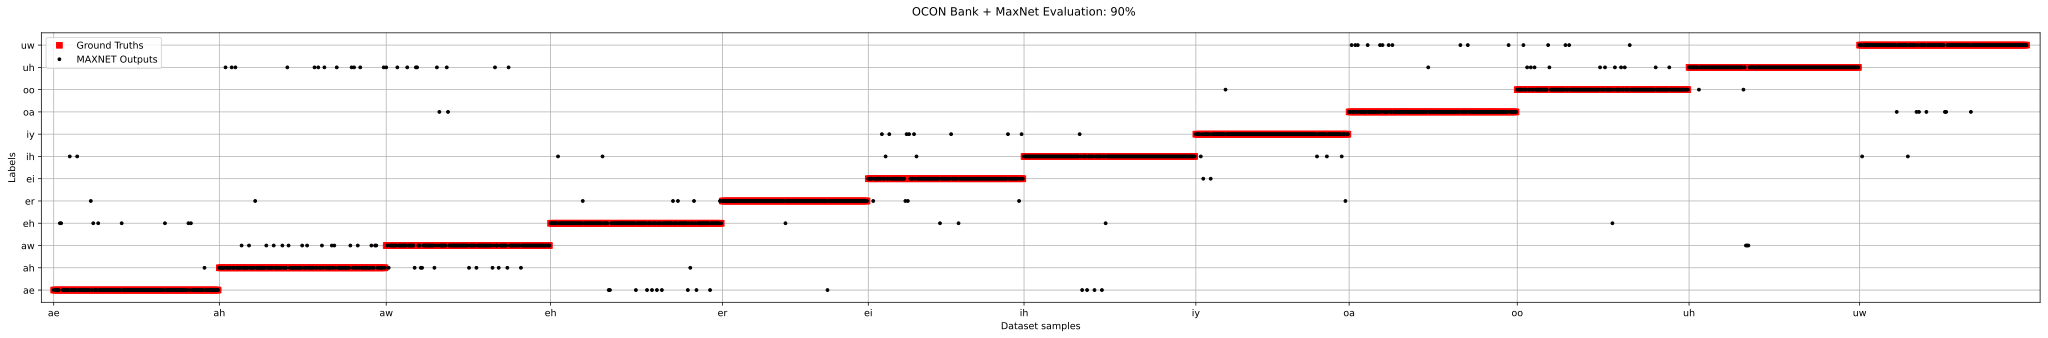

In [ ]:
# Evaluation Analysis Plot
plt.figure(figsize=(30, 5))
plt.suptitle(f'OCON Bank + MaxNet Evaluation: {maxnet_accuracy:.0f}%')

plot_x_ticks = end_idx[:]
plot_x_ticks = np.delete(plot_x_ticks, len(end_idx) - 1)
plot_y_ticks = [n for n in range(len(vowels))]

plt.plot(y_labels_raw_np, 'rs', label='Ground Truths')
plt.plot(maxnet_class_predictions, 'k.', label='MAXNET Outputs')
plt.xlabel('Dataset samples')
plt.xticks(ticks=plot_x_ticks, labels=vowels)
plt.xlim([-10, len(y_labels_raw_np) + 10])
plt.ylabel('Labels')
plt.yticks(ticks=plot_y_ticks, labels=vowels)
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.savefig('OCON_model_evaluation')
plt.show()